In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sagarsanghani","key":"7051cf0929a12c009d4b7811b4f8a8bc"}'}

In [2]:
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!mkdir ~/.kaggle

In [4]:
!mv kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d andyczhao/covidx-cxr2

100% 12.9G/12.9G [08:03<00:00, 35.9MB/s]
100% 12.9G/12.9G [08:03<00:00, 28.6MB/s]


In [7]:
!mkdir dataset

In [8]:
!unzip /content/covidx-cxr2.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train/aead3682-bdf4-4f43-8468-8e6ac3cd41fa.png  
  inflating: /content/dataset/train/aeae6cbc-d713-4760-845c-fcc93ed5ad64.png  
  inflating: /content/dataset/train/aeaf6ffd-ff7e-48cc-b31f-175a5e79b415.png  
  inflating: /content/dataset/train/aeb2a32c-595a-44c2-b827-c6ce0f6ff4f3.png  
  inflating: /content/dataset/train/aeb6324d-08d5-426b-9a60-bc39d5151edb.png  
  inflating: /content/dataset/train/aeb99fe0-d9f2-4122-8abf-e7f933f71f80.png  
  inflating: /content/dataset/train/aebb48db-2f6f-41ad-87e7-d90c5620187e.png  
  inflating: /content/dataset/train/aebb5625-cbea-4e11-9a9a-19708903ed1b.png  
  inflating: /content/dataset/train/aebf9717-f500-44ac-87cd-273f24e0c3ce.png  
  inflating: /content/dataset/train/aec1daa4-1910-4270-8de2-9abe6f3b1bf0.png  
  inflating: /content/dataset/train/aec5b2e5-ceff-4e21-a089-19efcd0c3d45.png  
  inflating: /content/dataset/train/aec849c0-4ef4-4d4e-9d09-573f1ce4cbd1.png  
 

In [ ]:
!rm /content/covidx-cxr2.zip

# Importing Libraries

In [9]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch
import os
from torchvision.io import read_image

In [10]:
data_path = "/content/dataset/train.txt"
img_path = "/content/dataset/train/"

# Data Exploration

In [11]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
img_color = cv2.imread('C:/Users/S_ANGH/Image Processing Data/data/train/e6eda78d-358e-42db-8abe-3edb36ca086b.png',1)

In [ ]:
inv_gamma = 1.0 / 2.2
table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
image = Image.fromarray(cv2.LUT(np.array(img_color), table))

In [ ]:
plt.imshow(img_color)
plt.show()

In [ ]:
plt.imshow(image)
plt.show()

# Data preprocessing

In [12]:
string_to_label = {"pneumonia": 0, "COVID-19":1, "normal":2}
label_to_class = {0:"pneumonia", 1:"COVID-19", 2:"normal"}

In [13]:
def preprocess_labels(path):
    df = pd.read_csv(path, sep=" ", header=None)
    df.columns = ["patient_id", "filename", "class", "data_source"]
    df['label'] = df['class'].map(string_to_label)
    df['label'] = df['label'].astype(int)
    df = df.drop("patient_id", axis=1)
    df = df.drop("data_source", axis=1)
    
    no_files = []
    count = 0
    
    for index, row in df.iterrows():
        file_path = row['filename']
        if os.path.isfile(os.path.join("/content/dataset/train/",file_path)):
            count += 1
            #print(f"The file {file_path} exists!")
        else:
            no_files.append(file_path)
    
    df = df[~df['filename'].isin(no_files)]

    df.to_csv('/content/dataset/train_annotations.csv', index=False)
    return '/content/dataset/train_annotations.csv'

In [14]:
pro_data_path = preprocess_labels(data_path)

In [15]:
train_df = pd.read_csv(pro_data_path)
train_df.head()

filename      class  label
0  SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....  pneumonia      0
1  SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....  pneumonia      0
2  SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...  pneumonia      0
3  SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...  pneumonia      0
4  SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...  pneumonia      0

In [16]:
train_df.shape

(29634, 3)

In [17]:
train_df['class'].value_counts()

COVID-19     15994
normal        8085
pneumonia     5555
Name: class, dtype: int64

# Loading Dataset

In [18]:
from PIL import Image

In [19]:
class CovidXRayDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, gamma=1.0):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.gamma = gamma

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #image = read_image(img_path)
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 2]
        
        inv_gamma = 1.0 / self.gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        image = Image.fromarray(cv2.LUT(np.array(image), table))

        if self.transform:
            image = self.transform(image)
            
        return image, label

In [20]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                                ])

full_dataset = CovidXRayDataset(pro_data_path, img_path, transform=transform)

In [21]:
train_size = int(0.75 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [22]:
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=32, shuffle=True)

## Custom Traning Model

In [23]:
from torch.nn import Conv2d, Linear, MaxPool2d, Module, BatchNorm2d
from torch.nn import functional as F

class CovidChestNet(Module):
    
    def __init__(self):
        ''' Initializing the model'''
        super(CovidChestNet, self).__init__()

        self.conv1_1 = Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.bn_1 = BatchNorm2d(16)
        
        self.conv2_1 = Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn_2 = BatchNorm2d(32)
        
        self.conv3_1 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.bn_3 = BatchNorm2d(64)
        
        self.conv4_1 = Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.bn_4 = BatchNorm2d(128)
        
        
        self.maxpool = MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = Linear(128 * 14 * 14, 1024)
        self.fc2 = Linear(1024, 512)
        self.fc3 = Linear(512, 3)
        
        
    def forward(self, x):
        
        x = F.relu(self.bn_1(self.conv1_1(x)), inplace=True)
        x = self.maxpool(x)
        
        x = F.relu(self.bn_2(self.conv2_1(x)), inplace=True)
        x = self.maxpool(x)
        
        x = F.relu(self.bn_3(self.conv3_1(x)), inplace=True)
        x = self.maxpool(x)
        
        x = F.relu(self.bn_4(self.conv4_1(x)), inplace=True)
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5)
        
        x = F.relu(self.fc2(x), inplace=True)
        x = F.dropout(x, 0.5)
        
        x = self.fc3(x)
        return x

In [24]:
model = CovidChestNet()
print(model)

CovidChestNet(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
)


## Training the Model

In [25]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
print(device)

def trainModel(model, train_loader, valid_loader, device, patience=5):
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr = learning_rate)
    
    train_losses = []
    train_accuracy = []
    
    val_losses = []
    val_accuracy = []
    
    best_accuracy = 0.0
    no_improvement_count = 0
    best_model_weights = None

    epochs = 20
    
    for i in range(1, epochs+1):
        start = time.time()
        
        running_loss = 0.0
        correct = 0

        # Training Mode
        model.train()
        for j, data in enumerate(train_loader, 0):
            
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum().item() 
            
        
        train_loss = running_loss/len(train_loader.dataset)
        train_losses.append(train_loss)
        accuracy = (correct / len(train_loader.dataset)) * 100
        train_accuracy.append(accuracy)

        # Validation Mode
        model.eval()
        total_valid_loss = 0.0
        total_valid_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_valid_accuracy += torch.sum(predicted == labels)
                
                
        avg_valid_loss = total_valid_loss / len(valid_loader.dataset)
        val_losses.append(avg_valid_loss)
        
        avg_valid_accuracy = total_valid_accuracy / len(valid_loader.dataset)
        val_accuracy.append(avg_valid_accuracy)
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tAccuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        i, train_loss, accuracy, avg_valid_loss, avg_valid_accuracy))
        elapsed = time.time() - start
        print("Elapsed time: " + time.strftime("%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:11], time.gmtime(elapsed)))

        if avg_valid_accuracy > best_accuracy:
            best_accuracy = avg_valid_accuracy
            best_model_weights = model.state_dict()
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f'Early stopping after {no_improvement_count} epochs without improvement in validation accuracy.')
            break
        
        #checkpoints
        torch.save(best_model_weights, "/content/dataset/checkpoints/CovidchestNet_weights_ckpt.pt")
        
    
    print("Finished Training")
    torch.save(best_model_weights, "/content/dataset/models/CovidchestNet_weights_ckpt.pt")
    #torch.save(model.state_dict(), "G:/AI Project/mask-classification-pytorch/saved_models/masknetv2_4.pt")
    torch.save(model, "/content/dataset/models/CovidchestNet_weights_ckpt_full.pt")
    
    return train_losses, train_accuracy, val_losses, val_accuracy

cuda


In [30]:
train_loss, train_accuracy, val_loss, val_accuracy = trainModel(model, train_data, val_data, device)

Epoch: 1 	Training Loss: 0.018726 	Accuracy: 78.348706 	Validation Loss: 0.407001 	Validation Accuracy: 0.845998
Elapsed time: 00:09:30.74
Epoch: 2 	Training Loss: 0.011796 	Accuracy: 85.961755 	Validation Loss: 0.363353 	Validation Accuracy: 0.863544
Elapsed time: 00:09:26.13
Epoch: 3 	Training Loss: 0.010656 	Accuracy: 87.797525 	Validation Loss: 0.353917 	Validation Accuracy: 0.867054
Elapsed time: 00:09:28.18
Epoch: 4 	Training Loss: 0.009282 	Accuracy: 89.354331 	Validation Loss: 0.291370 	Validation Accuracy: 0.895532
Elapsed time: 00:09:23.68
Epoch: 5 	Training Loss: 0.008453 	Accuracy: 90.524184 	Validation Loss: 0.272387 	Validation Accuracy: 0.907275
Elapsed time: 00:09:17.74
Epoch: 6 	Training Loss: 0.007533 	Accuracy: 91.572553 	Validation Loss: 0.287200 	Validation Accuracy: 0.904036
Elapsed time: 00:09:29.76
Epoch: 7 	Training Loss: 0.006946 	Accuracy: 92.134983 	Validation Loss: 0.263786 	Validation Accuracy: 0.906465
Elapsed time: 00:09:30.14
Epoch: 8 	Training Loss: 0.

# Model Evaluation

In [31]:
test_data_path = "/content/dataset/test.txt"
test_img_path = "/content/dataset/test"

def preprocess_test_labels(path):
    df = pd.read_csv(path, sep=" ", header=None)
    df.columns = ["patient_id", "filename", "class", "data_source"]
    df['label'] = df['class'].map(string_to_label)
    df['label'] = df['label'].astype(int)
    df = df.drop("patient_id", axis=1)
    df = df.drop("data_source", axis=1)
    
    no_files = []
    count = 0
    
    for index, row in df.iterrows():
        file_path = row['filename']
        if os.path.isfile(os.path.join("/content/dataset/test/",file_path)):
            count += 1
            #print(f"The file {file_path} exists!")
        else:
            no_files.append(file_path)
    
    df = df[~df['filename'].isin(no_files)]

    df.to_csv('/content/dataset/test_annotations.csv', index=False)
    return '/content/dataset/test_annotations.csv'

processed_test_data_path = preprocess_test_labels(test_data_path)


In [32]:
test_df = pd.read_csv(processed_test_data_path)
test_df.head(10)

filename     class  label
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  COVID-19      1
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  COVID-19      1
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  COVID-19      1
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  COVID-19      1
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  COVID-19      1
5   MIDRC-RICORD-1C-SITE2-000265-99793-1.png  COVID-19      1
6   MIDRC-RICORD-1C-SITE2-000159-61155-0.png  COVID-19      1
7  MIDRC-RICORD-1C-419639-003169-42019-0.png  COVID-19      1
8   MIDRC-RICORD-1C-SITE2-000238-25854-1.png  COVID-19      1
9  MIDRC-RICORD-1C-419639-001464-33260-0.png  COVID-19      1

In [33]:
test_df.shape

(400, 3)

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
#device = torch.device('cpu')

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                                ])

test_dataset = CovidXRayDataset(processed_test_data_path, test_img_path, transform=transform, gamma=1.15)

test_data = DataLoader(test_dataset, batch_size=32, shuffle=True)

path = "/content/dataset/models/CovidchestNet_weights_ckpt.pt"
test_model = CovidChestNet()
test_model.load_state_dict(torch.load(path))
test_model = test_model.to(device)
test_model.eval()

CovidChestNet(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=3, bias=True)
)

## Confusion Matrix

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns

[87.  84.5 89. ]


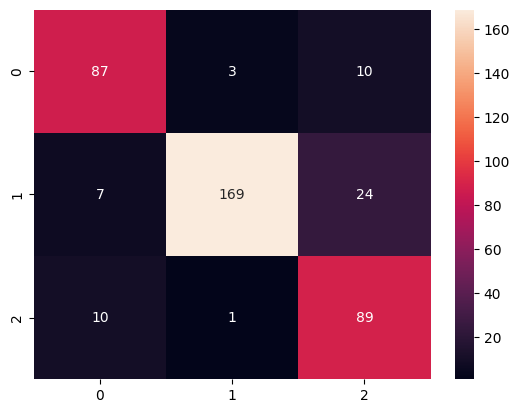

<Figure size 640x480 with 0 Axes>

In [36]:
y_pred=torch.zeros(0,dtype=torch.long, device=device)
y_true=torch.zeros(0,dtype=torch.long, device=device)

with torch.no_grad():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = test_model(inputs)
        _, preds = torch.max(outputs, 1)

        y_pred=torch.cat([y_pred,preds.view(-1)])
        y_true=torch.cat([y_true,labels.view(-1)])

conf_mat=confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy())

class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

cm = sns.heatmap(conf_mat, annot=True, fmt='d')

cm.plot()
plt.show()
plt.savefig('/content/dataset/confusion metrics.png')

In [45]:
overall_accuracy = 100*sum(conf_mat.diagonal()) / sum(sum(conf_mat))

In [47]:
print("Overall Accuracy: "+ str(overall_accuracy))

Overall Accuracy: 86.25


## Classification Report

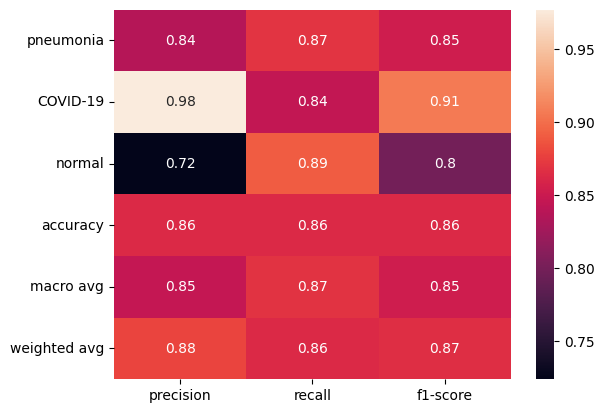

In [37]:
classification_repo = classification_report(y_true.cpu(), y_pred.cpu(), target_names=['pneumonia', 'COVID-19', 'normal'], output_dict=True)
svm =sns.heatmap(pd.DataFrame(classification_repo).iloc[:-1, :].T, annot=True)
figure = svm.get_figure()

figure.savefig('/content/dataset/Classification report.png')

In [38]:
pcrfs=()
pcrfs=precision_recall_fscore_support(y_true.cpu(), y_pred.cpu())
prec = pcrfs[0].tolist()
recall = pcrfs[1].tolist()
fscore = pcrfs[2].tolist()
support = pcrfs[3].tolist()

In [39]:
prec

[0.8365384615384616, 0.976878612716763, 0.7235772357723578]

In [40]:
recall

[0.87, 0.845, 0.89]

In [41]:
fscore

[0.8529411764705882, 0.906166219839142, 0.7982062780269058]

In [42]:
support

[100, 200, 100]